## Assignment 4 - ImageCLEF Medical Caption Task 2019

Fisrt, the imports...

In [174]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import matplotlib.image as mplimg
import os
import pandas as pd
from tqdm import tqdm
import numpy as np
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

Read csv files 

* Training

In [115]:
train_concepts = pd.read_csv("ImageCLEF2019/train_concepts.csv")
##split "tags" to a list of tags
train_concepts["tags_sep"] = train_concepts["tags"].str.split(";")
train_concepts.head(5)

,image,tags,tags_sep
0,ROCO_CLEF_07350,C0203126;C0203051,"[C0203126, C0203051]"
1,ROCO_CLEF_19073,C0772294;C0023884;C0221198;C0412555;C0041618,"[C0772294, C0023884, C0221198, C0412555, C0041618]"
2,ROCO_CLEF_60501,C0233492;C2985494;C0262950;C1306232,"[C0233492, C2985494, C0262950, C1306232]"
3,ROCO_CLEF_05564,C0521530;C0817096,"[C0521530, C0817096]"
4,ROCO_CLEF_55020,C0935598;C1184743,"[C0935598, C1184743]"


In [116]:
train_concepts.shape

(56629, 3)

* Validation

In [117]:
val_concepts = pd.read_csv("ImageCLEF2019/val_concepts.csv")
##split "tags" to a list of tags
val_concepts["tags_sep"] = val_concepts["tags"].str.split(";")
val_concepts.head(1)

,image,tags,tags_sep
0,ROCO_CLEF_64017,C0001074;C3203359;C0041618,"[C0001074, C3203359, C0041618]"


In [118]:
val_concepts.shape

(14157, 3)

* Tag ids - names

In [119]:
string_concepts = pd.read_csv("ImageCLEF2019/string_concepts.csv",
                              sep = "\t",
                              header = None,
                              names = ["tag", "name"])
string_concepts.head(5)

,tag,name
0,C0032143,r-tpa
1,C0225516,lower hypopharyngeal region
2,C0825429,bone surface
3,C0020461,excessive potassium in the blood
4,C0947912,proximal muscle weakness due to defect at the neuromuscular junction


In [120]:
string_concepts.shape

(5528, 2)

## Data Exploration

Plot images, fetch tags and tag names

* training images

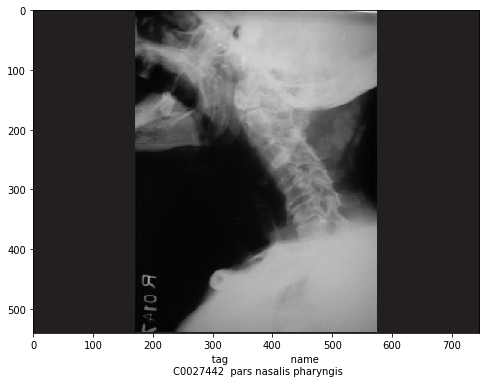

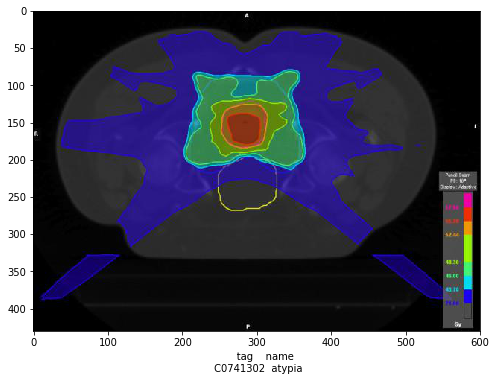

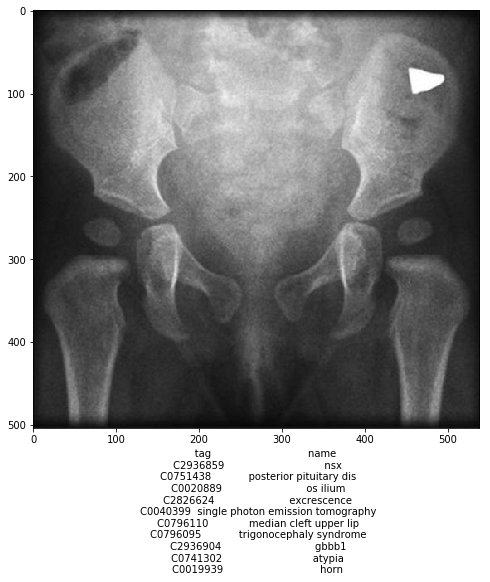

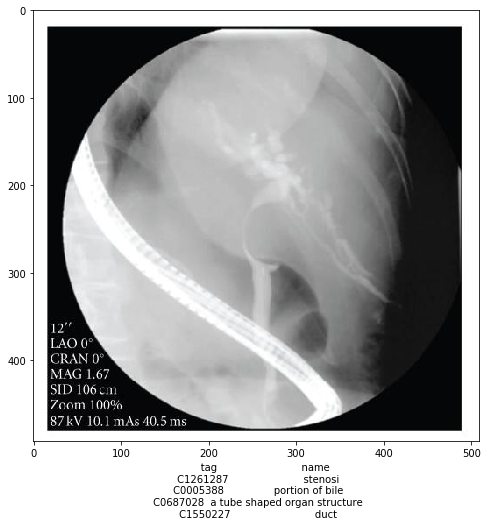

In [8]:
##get 4 images from directory
for image_name in os.listdir("ImageCLEF2019/training-set/")[0:4]:
    image_as_array = mplimg.imread("ImageCLEF2019/training-set/" + image_name)

    ##tags under image
    list_of_tags = train_concepts["tags_sep"][train_concepts["image"]+".jpg" == image_name].tolist()
    names = string_concepts[["tag", "name"]][string_concepts["tag"].isin(list_of_tags[0])]

    ##plot
    plt.figure(figsize=(8,8))
    plt.imshow(image_as_array)
    plt.xlabel(names.to_string(index=False), horizontalalignment = "center")
    plt.show()
    plt.close()

* validation images

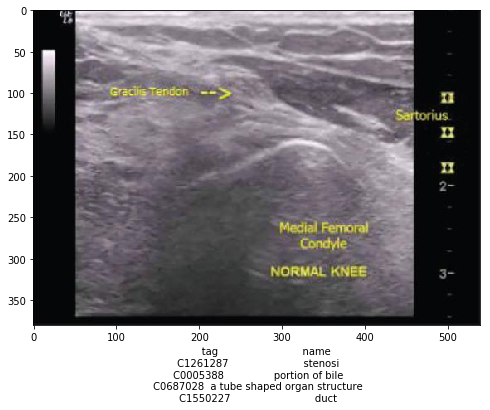

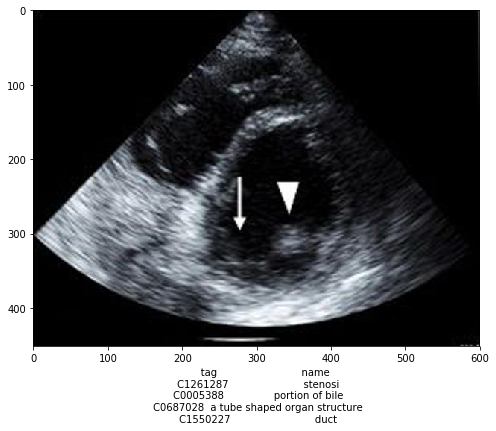

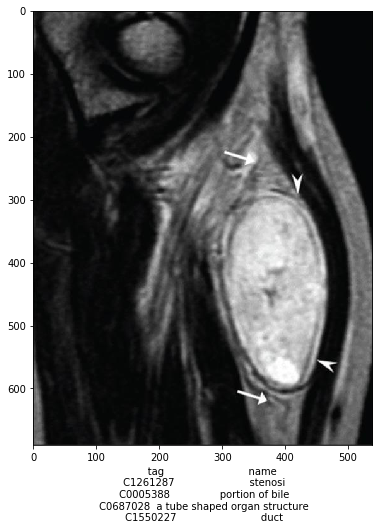

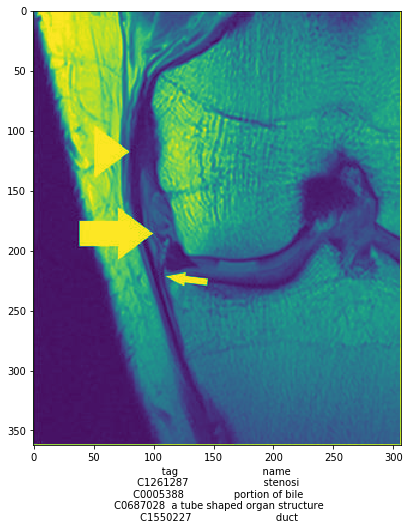

In [9]:
for image_name in os.listdir("ImageCLEF2019/validation-set/")[0:4]:
    image_as_array = mplimg.imread("ImageCLEF2019/validation-set/" + image_name)
    
    list_of_tags = val_concepts["tags_sep"][val_concepts["image"]+".jpg" == image_name].tolist()
    names_val = string_concepts[["tag", "name"]][string_concepts["tag"].isin(list_of_tags[0])]
    
    plt.figure(figsize=(8,8))
    plt.imshow(image_as_array)
    plt.xlabel(names.to_string(index=False), horizontalalignment = "center")
    plt.show()
    plt.close()

Total number of tags is 5528

In [10]:
string_concepts["tag"].nunique()

5528

Finding 10 most common tags and how many times each one appeared

* training images

In [11]:
c = Counter()

for index, row in train_concepts.iterrows():
    c += Counter(set(row["tags_sep"]))

In [12]:
print("--Tag----Freq--Name--")
for tag in c.most_common(10):
    print(tag[0], tag[1], string_concepts["name"][string_concepts["tag"] == tag[0]].to_string(index = False))

--Tag----Freq--Name--
C0441633 6733  diagnostic scanning
C0043299 6321  x-ray procedure
C1962945 6318  radiogr
C0040395 6235  tomogr
C0034579 6127  pantomogr
C0817096 5981  thoracics
C0040405 5801  x-ray computer assisted tomography
C1548003 5159  radiograph
C0221198 4513  visible lesion
C0772294 4512  alesion


* validation images

In [13]:
c = Counter()

for index, row in val_concepts.iterrows():
    c += Counter(set(row["tags_sep"]))
    
print("--Tag----Freq--Name--")
for tag in c.most_common(10):
    print(tag[0], tag[1], string_concepts["name"][string_concepts["tag"] == tag[0]].to_string(index = False))

--Tag----Freq--Name--
C0441633 1692  diagnostic scanning
C0043299 1585  x-ray procedure
C1962945 1584  radiogr
C0817096 1489  thoracics
C0040395 1462  tomogr
C0034579 1437  pantomogr
C0040405 1363  x-ray computer assisted tomography
C1548003 1269  radiograph
C0221198 1165  visible lesion
C0772294 1165  alesion


Tags per image: new column added to the existing data frame (no_of_tags)

* training images

In [14]:
train_concepts["no_of_tags"] = train_concepts["tags_sep"].str.len()
train_concepts.head(5)

,image,tags,tags_sep,no_of_tags
0,ROCO_CLEF_07350,C0203126;C0203051,"[C0203126, C0203051]",2
1,ROCO_CLEF_19073,C0772294;C0023884;C0221198;C0412555;C0041618,"[C0772294, C0023884, C0221198, C0412555, C0041...",5
2,ROCO_CLEF_60501,C0233492;C2985494;C0262950;C1306232,"[C0233492, C2985494, C0262950, C1306232]",4
3,ROCO_CLEF_05564,C0521530;C0817096,"[C0521530, C0817096]",2
4,ROCO_CLEF_55020,C0935598;C1184743,"[C0935598, C1184743]",2


In [15]:
print("Minumum tags  per image: ", train_concepts["no_of_tags"].min())
print("Maximum tags  per image: ", train_concepts["no_of_tags"].max())
print("Average tags  per image: ", train_concepts["no_of_tags"].mean())

Minumum tags  per image:  1
Maximum tags  per image:  72
Average tags  per image:  6.106871037807484


In [16]:
##deleting unwanted columns
del train_concepts["tags"]
del train_concepts["no_of_tags"]

* validation images

In [17]:
val_concepts["no_of_tags"] = val_concepts["tags_sep"].str.len()
val_concepts.head(5)

,image,tags,tags_sep,no_of_tags
0,ROCO_CLEF_64017,C0001074;C3203359;C0041618,"[C0001074, C3203359, C0041618]",3
1,ROCO_CLEF_39073,C0027530;C1610719;C0065967;C1704258;C0883242;C...,"[C0027530, C1610719, C0065967, C1704258, C0883...",10
2,ROCO_CLEF_18028,C1265876;C1293134;C0029053;C0034579;C0025066;C...,"[C1265876, C1293134, C0029053, C0034579, C0025...",9
3,ROCO_CLEF_02052,C0040426;C1962945;C0043299;C0036849;C0150312,"[C0040426, C1962945, C0043299, C0036849, C0150...",5
4,ROCO_CLEF_67927,C0184666;C4085643;C4049705;C4049706;C4321335;C...,"[C0184666, C4085643, C4049705, C4049706, C4321...",9


In [18]:
print("Minumum tags  per image: ", val_concepts["no_of_tags"].min())
print("Maximum tags  per image: ", val_concepts["no_of_tags"].max())
print("Average tags  per image: ", val_concepts["no_of_tags"].mean())

Minumum tags  per image:  1
Maximum tags  per image:  77
Average tags  per image:  6.140213322031504


In [19]:
##deleting unwanted columns
del val_concepts["tags"]
del val_concepts["no_of_tags"]

## Data Preprocessing

Prepare to load images

* Training

In [20]:
##adding file type(.jpg) at the end of image name
train_concepts["image"] += ".jpg"

In [21]:
##create generator
##using flow_from_dataframe method to load images
##choosing batch size and rescaling images
##setting as classs the 5528 tags from string_concepts dataframe

train_datagen = ImageDataGenerator(rescale = 1./255.)

train_generator = train_datagen.flow_from_dataframe(dataframe = train_concepts,
                                                    directory = "ImageCLEF2019/training-set/",
                                                    x_col = "image",
                                                    y_col = "tags_sep",
                                                    batch_size = 64,
                                                    seed = 666,
                                                    shuffle = True,
                                                    class_mode = "categorical",
                                                    classes = string_concepts["tag"].tolist(),
                                                    target_size = (96,96))

Found 56629 validated image filenames belonging to 5528 classes.


* Validation

In [22]:
##adding file type(.jpg) at the end of image name
val_concepts["image"] += ".jpg"

In [23]:
##create generator
##using flow_from_dataframe method to load images
##choosing batch size and rescaling images
##setting as classs the 5528 tags from string_concepts dataframe

validation_datagen = ImageDataGenerator(rescale = 1./255.)

validation_generator = validation_datagen.flow_from_dataframe(dataframe = val_concepts,
                                                              directory = "ImageCLEF2019/validation-set/",
                                                              x_col = "image",
                                                              y_col = "tags_sep",
                                                              batch_size = 64,
                                                              seed = 666,
                                                              shuffle = True,
                                                              class_mode = "categorical",
                                                              classes = string_concepts["tag"].tolist(),
                                                              target_size = (96,96))

Found 14157 validated image filenames belonging to 5528 classes.


## Build a Baseline

## Build a Neural Network

Chose to use the pretrained MobileNetV2. The input is a set of RGB 96x96 images. Instead of model's top layer, I am using a Dense layer with a sigmoid activation function.

In [24]:
##pretrained model
my_model = MobileNetV2(input_shape = (96,96,3),
                       alpha = 1.0,
                       include_top = False,
                       weights = "imagenet",
                       pooling = "avg")

In [25]:
##my output
x = my_model.output
out_preds = Dense(5528, activation = "sigmoid")(x)

In [26]:
##building the complete model
full_model = Model(inputs = my_model.input, outputs = out_preds)

In [27]:
##freezing all layers of the MobileNet model
my_model.trainable = False

In [28]:
full_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 97, 97, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 48, 48, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 48, 48, 32)   128         Conv1[0][0]                      
______________________________________________________________________________________________

block_4_expand_relu (ReLU)      (None, 12, 12, 192)  0           block_4_expand_BN[0][0]          
__________________________________________________________________________________________________
block_4_depthwise (DepthwiseCon (None, 12, 12, 192)  1728        block_4_expand_relu[0][0]        
__________________________________________________________________________________________________
block_4_depthwise_BN (BatchNorm (None, 12, 12, 192)  768         block_4_depthwise[0][0]          
__________________________________________________________________________________________________
block_4_depthwise_relu (ReLU)   (None, 12, 12, 192)  0           block_4_depthwise_BN[0][0]       
__________________________________________________________________________________________________
block_4_project (Conv2D)        (None, 12, 12, 32)   6144        block_4_depthwise_relu[0][0]     
__________________________________________________________________________________________________
block_4_pr

__________________________________________________________________________________________________
block_8_project (Conv2D)        (None, 6, 6, 64)     24576       block_8_depthwise_relu[0][0]     
__________________________________________________________________________________________________
block_8_project_BN (BatchNormal (None, 6, 6, 64)     256         block_8_project[0][0]            
__________________________________________________________________________________________________
block_8_add (Add)               (None, 6, 6, 64)     0           block_7_add[0][0]                
                                                                 block_8_project_BN[0][0]         
__________________________________________________________________________________________________
block_9_expand (Conv2D)         (None, 6, 6, 384)    24576       block_8_add[0][0]                
__________________________________________________________________________________________________
block_9_ex

__________________________________________________________________________________________________
block_13_expand_BN (BatchNormal (None, 6, 6, 576)    2304        block_13_expand[0][0]            
__________________________________________________________________________________________________
block_13_expand_relu (ReLU)     (None, 6, 6, 576)    0           block_13_expand_BN[0][0]         
__________________________________________________________________________________________________
block_13_pad (ZeroPadding2D)    (None, 7, 7, 576)    0           block_13_expand_relu[0][0]       
__________________________________________________________________________________________________
block_13_depthwise (DepthwiseCo (None, 3, 3, 576)    5184        block_13_pad[0][0]               
__________________________________________________________________________________________________
block_13_depthwise_BN (BatchNor (None, 3, 3, 576)    2304        block_13_depthwise[0][0]         
__________

__________________________________________________________________________________________________


In [29]:
##compiling and training the full model
full_model.compile(loss = "binary_crossentropy", optimizer = Adam(lr = 0.001))

In [30]:
#early = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
#saver = ModelCheckpoint('sofia_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [31]:
full_model.fit_generator(generator  = train_generator,
                         steps_per_epoch = len(train_generator),
                         validation_data = validation_generator,
                         validation_steps = len(validation_generator),
                         verbose = 1,
                         epochs = 4
)

Epoch 1/4


314/885 [=========>....................] - ETA: 40:25 - loss: 0.72 - ETA: 37:59 - loss: 0.62 - ETA: 37:04 - loss: 0.53 - ETA: 36:24 - loss: 0.46 - ETA: 37:12 - loss: 0.40 - ETA: 38:44 - loss: 0.36 - ETA: 39:19 - loss: 0.32 - ETA: 40:00 - loss: 0.29 - ETA: 39:40 - loss: 0.26 - ETA: 39:22 - loss: 0.24 - ETA: 39:09 - loss: 0.22 - ETA: 39:08 - loss: 0.20 - ETA: 38:59 - loss: 0.19 - ETA: 38:47 - loss: 0.18 - ETA: 39:03 - loss: 0.16 - ETA: 38:51 - loss: 0.15 - ETA: 38:42 - loss: 0.15 - ETA: 38:42 - loss: 0.14 - ETA: 38:33 - loss: 0.13 - ETA: 38:24 - loss: 0.13 - ETA: 38:16 - loss: 0.12 - ETA: 38:07 - loss: 0.11 - ETA: 38:01 - loss: 0.11 - ETA: 37:59 - loss: 0.11 - ETA: 37:55 - loss: 0.10 - ETA: 37:50 - loss: 0.10 - ETA: 37:44 - loss: 0.09 - ETA: 37:38 - loss: 0.09 - ETA: 37:32 - loss: 0.09 - ETA: 37:28 - loss: 0.09 - ETA: 37:27 - loss: 0.08 - ETA: 37:21 - loss: 0.08 - ETA: 37:16 - loss: 0.08 - ETA: 37:11 - loss: 0.08 - ETA: 37:06 - loss: 0.07 - ETA: 37:02 - loss: 0.07 - ETA: 37:01 - loss: 0.

628/885 [====================>.........] - ETA: 25:08 - loss: 0.01 - ETA: 25:05 - loss: 0.01 - ETA: 25:03 - loss: 0.01 - ETA: 25:00 - loss: 0.01 - ETA: 24:57 - loss: 0.01 - ETA: 24:55 - loss: 0.01 - ETA: 24:52 - loss: 0.01 - ETA: 24:50 - loss: 0.01 - ETA: 24:47 - loss: 0.01 - ETA: 24:44 - loss: 0.01 - ETA: 24:42 - loss: 0.01 - ETA: 24:39 - loss: 0.01 - ETA: 24:37 - loss: 0.01 - ETA: 24:34 - loss: 0.01 - ETA: 24:31 - loss: 0.01 - ETA: 24:29 - loss: 0.01 - ETA: 24:27 - loss: 0.01 - ETA: 24:25 - loss: 0.01 - ETA: 24:23 - loss: 0.01 - ETA: 24:21 - loss: 0.01 - ETA: 24:18 - loss: 0.01 - ETA: 24:16 - loss: 0.01 - ETA: 24:14 - loss: 0.01 - ETA: 24:12 - loss: 0.01 - ETA: 24:10 - loss: 0.01 - ETA: 24:07 - loss: 0.01 - ETA: 24:04 - loss: 0.01 - ETA: 24:02 - loss: 0.01 - ETA: 23:59 - loss: 0.01 - ETA: 23:56 - loss: 0.01 - ETA: 23:54 - loss: 0.01 - ETA: 23:51 - loss: 0.01 - ETA: 23:48 - loss: 0.01 - ETA: 23:46 - loss: 0.01 - ETA: 23:43 - loss: 0.01 - ETA: 23:40 - loss: 0.01 - ETA: 23:38 - loss: 0.

885/885 [==============================] - ETA: 12:19 - loss: 0.01 - ETA: 12:17 - loss: 0.01 - ETA: 12:14 - loss: 0.01 - ETA: 12:11 - loss: 0.01 - ETA: 12:08 - loss: 0.01 - ETA: 12:05 - loss: 0.01 - ETA: 12:02 - loss: 0.01 - ETA: 12:00 - loss: 0.01 - ETA: 11:57 - loss: 0.01 - ETA: 11:55 - loss: 0.01 - ETA: 11:52 - loss: 0.01 - ETA: 11:49 - loss: 0.01 - ETA: 11:47 - loss: 0.01 - ETA: 11:44 - loss: 0.01 - ETA: 11:41 - loss: 0.01 - ETA: 11:38 - loss: 0.01 - ETA: 11:36 - loss: 0.01 - ETA: 11:33 - loss: 0.01 - ETA: 11:30 - loss: 0.01 - ETA: 11:27 - loss: 0.01 - ETA: 11:24 - loss: 0.01 - ETA: 11:21 - loss: 0.01 - ETA: 11:18 - loss: 0.01 - ETA: 11:15 - loss: 0.01 - ETA: 11:13 - loss: 0.01 - ETA: 11:10 - loss: 0.01 - ETA: 11:07 - loss: 0.01 - ETA: 11:04 - loss: 0.01 - ETA: 11:01 - loss: 0.01 - ETA: 10:58 - loss: 0.01 - ETA: 10:55 - loss: 0.01 - ETA: 10:53 - loss: 0.01 - ETA: 10:51 - loss: 0.01 - ETA: 10:48 - loss: 0.01 - ETA: 10:45 - loss: 0.01 - ETA: 10:43 - loss: 0.01 - ETA: 10:40 - loss: 0.

314/885 [=========>....................] - ETA: 42:53 - loss: 0.00 - ETA: 45:49 - loss: 0.00 - ETA: 45:29 - loss: 0.00 - ETA: 45:20 - loss: 0.00 - ETA: 44:52 - loss: 0.00 - ETA: 44:41 - loss: 0.00 - ETA: 44:32 - loss: 0.00 - ETA: 44:45 - loss: 0.00 - ETA: 44:42 - loss: 0.00 - ETA: 44:31 - loss: 0.00 - ETA: 44:17 - loss: 0.00 - ETA: 44:09 - loss: 0.00 - ETA: 44:09 - loss: 0.00 - ETA: 44:13 - loss: 0.00 - ETA: 44:06 - loss: 0.00 - ETA: 44:00 - loss: 0.00 - ETA: 43:50 - loss: 0.00 - ETA: 43:54 - loss: 0.00 - ETA: 44:20 - loss: 0.00 - ETA: 44:11 - loss: 0.00 - ETA: 44:08 - loss: 0.00 - ETA: 44:05 - loss: 0.00 - ETA: 44:04 - loss: 0.00 - ETA: 44:53 - loss: 0.00 - ETA: 45:11 - loss: 0.00 - ETA: 45:13 - loss: 0.00 - ETA: 45:08 - loss: 0.00 - ETA: 45:31 - loss: 0.00 - ETA: 45:42 - loss: 0.00 - ETA: 45:39 - loss: 0.00 - ETA: 45:33 - loss: 0.00 - ETA: 45:28 - loss: 0.00 - ETA: 45:19 - loss: 0.00 - ETA: 45:10 - loss: 0.00 - ETA: 45:01 - loss: 0.00 - ETA: 44:52 - loss: 0.00 - ETA: 44:45 - loss: 0.

628/885 [====================>.........] - ETA: 28:40 - loss: 0.00 - ETA: 28:37 - loss: 0.00 - ETA: 28:33 - loss: 0.00 - ETA: 28:30 - loss: 0.00 - ETA: 28:27 - loss: 0.00 - ETA: 28:23 - loss: 0.00 - ETA: 28:20 - loss: 0.00 - ETA: 28:17 - loss: 0.00 - ETA: 28:13 - loss: 0.00 - ETA: 28:10 - loss: 0.00 - ETA: 28:07 - loss: 0.00 - ETA: 28:03 - loss: 0.00 - ETA: 28:00 - loss: 0.00 - ETA: 27:56 - loss: 0.00 - ETA: 27:53 - loss: 0.00 - ETA: 27:49 - loss: 0.00 - ETA: 27:46 - loss: 0.00 - ETA: 27:43 - loss: 0.00 - ETA: 27:39 - loss: 0.00 - ETA: 27:36 - loss: 0.00 - ETA: 27:32 - loss: 0.00 - ETA: 27:29 - loss: 0.00 - ETA: 27:26 - loss: 0.00 - ETA: 27:23 - loss: 0.00 - ETA: 27:19 - loss: 0.00 - ETA: 27:16 - loss: 0.00 - ETA: 27:12 - loss: 0.00 - ETA: 27:09 - loss: 0.00 - ETA: 27:06 - loss: 0.00 - ETA: 27:03 - loss: 0.00 - ETA: 26:59 - loss: 0.00 - ETA: 26:56 - loss: 0.00 - ETA: 26:53 - loss: 0.00 - ETA: 26:49 - loss: 0.00 - ETA: 26:46 - loss: 0.00 - ETA: 26:43 - loss: 0.00 - ETA: 26:39 - loss: 0.

885/885 [==============================] - ETA: 12:39 - loss: 0.00 - ETA: 12:36 - loss: 0.00 - ETA: 12:33 - loss: 0.00 - ETA: 12:30 - loss: 0.00 - ETA: 12:27 - loss: 0.00 - ETA: 12:24 - loss: 0.00 - ETA: 12:21 - loss: 0.00 - ETA: 12:18 - loss: 0.00 - ETA: 12:15 - loss: 0.00 - ETA: 12:12 - loss: 0.00 - ETA: 12:09 - loss: 0.00 - ETA: 12:06 - loss: 0.00 - ETA: 12:03 - loss: 0.00 - ETA: 12:00 - loss: 0.00 - ETA: 11:57 - loss: 0.00 - ETA: 11:54 - loss: 0.00 - ETA: 11:51 - loss: 0.00 - ETA: 11:48 - loss: 0.00 - ETA: 11:44 - loss: 0.00 - ETA: 11:41 - loss: 0.00 - ETA: 11:38 - loss: 0.00 - ETA: 11:35 - loss: 0.00 - ETA: 11:32 - loss: 0.00 - ETA: 11:29 - loss: 0.00 - ETA: 11:26 - loss: 0.00 - ETA: 11:23 - loss: 0.00 - ETA: 11:21 - loss: 0.00 - ETA: 11:18 - loss: 0.00 - ETA: 11:15 - loss: 0.00 - ETA: 11:12 - loss: 0.00 - ETA: 11:09 - loss: 0.00 - ETA: 11:06 - loss: 0.00 - ETA: 11:03 - loss: 0.00 - ETA: 11:00 - loss: 0.00 - ETA: 10:57 - loss: 0.00 - ETA: 10:54 - loss: 0.00 - ETA: 10:51 - loss: 0.

314/885 [=========>....................] - ETA: 40:33 - loss: 0.00 - ETA: 40:08 - loss: 0.00 - ETA: 40:10 - loss: 0.00 - ETA: 40:41 - loss: 0.00 - ETA: 40:33 - loss: 0.00 - ETA: 40:23 - loss: 0.00 - ETA: 40:17 - loss: 0.00 - ETA: 40:12 - loss: 0.00 - ETA: 40:07 - loss: 0.00 - ETA: 40:18 - loss: 0.00 - ETA: 40:08 - loss: 0.00 - ETA: 39:57 - loss: 0.00 - ETA: 39:50 - loss: 0.00 - ETA: 39:42 - loss: 0.00 - ETA: 39:35 - loss: 0.00 - ETA: 39:39 - loss: 0.00 - ETA: 39:35 - loss: 0.00 - ETA: 39:27 - loss: 0.00 - ETA: 39:22 - loss: 0.00 - ETA: 39:16 - loss: 0.00 - ETA: 39:14 - loss: 0.00 - ETA: 39:16 - loss: 0.00 - ETA: 39:12 - loss: 0.00 - ETA: 39:07 - loss: 0.00 - ETA: 39:03 - loss: 0.00 - ETA: 38:57 - loss: 0.00 - ETA: 38:55 - loss: 0.00 - ETA: 38:55 - loss: 0.00 - ETA: 38:51 - loss: 0.00 - ETA: 38:46 - loss: 0.00 - ETA: 38:42 - loss: 0.00 - ETA: 38:38 - loss: 0.00 - ETA: 38:35 - loss: 0.00 - ETA: 38:35 - loss: 0.00 - ETA: 38:31 - loss: 0.00 - ETA: 38:27 - loss: 0.00 - ETA: 38:25 - loss: 0.

628/885 [====================>.........] - ETA: 27:12 - loss: 0.00 - ETA: 27:09 - loss: 0.00 - ETA: 27:06 - loss: 0.00 - ETA: 27:03 - loss: 0.00 - ETA: 27:00 - loss: 0.00 - ETA: 26:59 - loss: 0.00 - ETA: 26:57 - loss: 0.00 - ETA: 26:56 - loss: 0.00 - ETA: 26:53 - loss: 0.00 - ETA: 26:50 - loss: 0.00 - ETA: 26:47 - loss: 0.00 - ETA: 26:44 - loss: 0.00 - ETA: 26:41 - loss: 0.00 - ETA: 26:38 - loss: 0.00 - ETA: 26:35 - loss: 0.00 - ETA: 26:31 - loss: 0.00 - ETA: 26:28 - loss: 0.00 - ETA: 26:27 - loss: 0.00 - ETA: 26:25 - loss: 0.00 - ETA: 26:23 - loss: 0.00 - ETA: 26:21 - loss: 0.00 - ETA: 26:21 - loss: 0.00 - ETA: 26:18 - loss: 0.00 - ETA: 26:18 - loss: 0.00 - ETA: 26:19 - loss: 0.00 - ETA: 26:19 - loss: 0.00 - ETA: 26:19 - loss: 0.00 - ETA: 26:16 - loss: 0.00 - ETA: 26:14 - loss: 0.00 - ETA: 26:11 - loss: 0.00 - ETA: 26:07 - loss: 0.00 - ETA: 26:08 - loss: 0.00 - ETA: 26:08 - loss: 0.00 - ETA: 26:12 - loss: 0.00 - ETA: 26:12 - loss: 0.00 - ETA: 26:10 - loss: 0.00 - ETA: 26:08 - loss: 0.

885/885 [==============================] - ETA: 13:28 - loss: 0.00 - ETA: 13:25 - loss: 0.00 - ETA: 13:22 - loss: 0.00 - ETA: 13:19 - loss: 0.00 - ETA: 13:15 - loss: 0.00 - ETA: 13:12 - loss: 0.00 - ETA: 13:09 - loss: 0.00 - ETA: 13:05 - loss: 0.00 - ETA: 13:02 - loss: 0.00 - ETA: 12:59 - loss: 0.00 - ETA: 12:55 - loss: 0.00 - ETA: 12:52 - loss: 0.00 - ETA: 12:49 - loss: 0.00 - ETA: 12:46 - loss: 0.00 - ETA: 12:42 - loss: 0.00 - ETA: 12:39 - loss: 0.00 - ETA: 12:36 - loss: 0.00 - ETA: 12:33 - loss: 0.00 - ETA: 12:30 - loss: 0.00 - ETA: 12:27 - loss: 0.00 - ETA: 12:24 - loss: 0.00 - ETA: 12:21 - loss: 0.00 - ETA: 12:18 - loss: 0.00 - ETA: 12:15 - loss: 0.00 - ETA: 12:12 - loss: 0.00 - ETA: 12:09 - loss: 0.00 - ETA: 12:06 - loss: 0.00 - ETA: 12:02 - loss: 0.00 - ETA: 12:00 - loss: 0.00 - ETA: 11:57 - loss: 0.00 - ETA: 11:54 - loss: 0.00 - ETA: 11:51 - loss: 0.00 - ETA: 11:48 - loss: 0.00 - ETA: 11:44 - loss: 0.00 - ETA: 11:41 - loss: 0.00 - ETA: 11:38 - loss: 0.00 - ETA: 11:35 - loss: 0.

314/885 [=========>....................] - ETA: 38:44 - loss: 0.00 - ETA: 38:43 - loss: 0.00 - ETA: 39:04 - loss: 0.00 - ETA: 39:35 - loss: 0.00 - ETA: 39:29 - loss: 0.00 - ETA: 39:25 - loss: 0.00 - ETA: 39:17 - loss: 0.00 - ETA: 39:14 - loss: 0.00 - ETA: 39:18 - loss: 0.00 - ETA: 39:28 - loss: 0.00 - ETA: 39:22 - loss: 0.00 - ETA: 39:17 - loss: 0.00 - ETA: 39:15 - loss: 0.00 - ETA: 39:11 - loss: 0.00 - ETA: 39:11 - loss: 0.00 - ETA: 39:12 - loss: 0.00 - ETA: 39:07 - loss: 0.00 - ETA: 39:04 - loss: 0.00 - ETA: 39:02 - loss: 0.00 - ETA: 38:57 - loss: 0.00 - ETA: 38:57 - loss: 0.00 - ETA: 38:56 - loss: 0.00 - ETA: 38:52 - loss: 0.00 - ETA: 38:49 - loss: 0.00 - ETA: 38:46 - loss: 0.00 - ETA: 38:43 - loss: 0.00 - ETA: 38:44 - loss: 0.00 - ETA: 38:43 - loss: 0.00 - ETA: 38:39 - loss: 0.00 - ETA: 38:35 - loss: 0.00 - ETA: 38:32 - loss: 0.00 - ETA: 38:28 - loss: 0.00 - ETA: 38:27 - loss: 0.00 - ETA: 38:24 - loss: 0.00 - ETA: 38:20 - loss: 0.00 - ETA: 38:18 - loss: 0.00 - ETA: 38:16 - loss: 0.

628/885 [====================>.........] - ETA: 25:30 - loss: 0.00 - ETA: 25:27 - loss: 0.00 - ETA: 25:24 - loss: 0.00 - ETA: 25:22 - loss: 0.00 - ETA: 25:19 - loss: 0.00 - ETA: 25:16 - loss: 0.00 - ETA: 25:14 - loss: 0.00 - ETA: 25:11 - loss: 0.00 - ETA: 25:08 - loss: 0.00 - ETA: 25:05 - loss: 0.00 - ETA: 25:03 - loss: 0.00 - ETA: 25:00 - loss: 0.00 - ETA: 24:57 - loss: 0.00 - ETA: 24:54 - loss: 0.00 - ETA: 24:52 - loss: 0.00 - ETA: 24:49 - loss: 0.00 - ETA: 24:46 - loss: 0.00 - ETA: 24:44 - loss: 0.00 - ETA: 24:41 - loss: 0.00 - ETA: 24:38 - loss: 0.00 - ETA: 24:35 - loss: 0.00 - ETA: 24:33 - loss: 0.00 - ETA: 24:30 - loss: 0.00 - ETA: 24:27 - loss: 0.00 - ETA: 24:25 - loss: 0.00 - ETA: 24:22 - loss: 0.00 - ETA: 24:19 - loss: 0.00 - ETA: 24:16 - loss: 0.00 - ETA: 24:14 - loss: 0.00 - ETA: 24:11 - loss: 0.00 - ETA: 24:08 - loss: 0.00 - ETA: 24:06 - loss: 0.00 - ETA: 24:03 - loss: 0.00 - ETA: 24:00 - loss: 0.00 - ETA: 23:57 - loss: 0.00 - ETA: 23:55 - loss: 0.00 - ETA: 23:53 - loss: 0.

885/885 [==============================] - ETA: 11:22 - loss: 0.00 - ETA: 11:19 - loss: 0.00 - ETA: 11:16 - loss: 0.00 - ETA: 11:14 - loss: 0.00 - ETA: 11:11 - loss: 0.00 - ETA: 11:08 - loss: 0.00 - ETA: 11:06 - loss: 0.00 - ETA: 11:03 - loss: 0.00 - ETA: 11:00 - loss: 0.00 - ETA: 10:58 - loss: 0.00 - ETA: 10:55 - loss: 0.00 - ETA: 10:52 - loss: 0.00 - ETA: 10:50 - loss: 0.00 - ETA: 10:47 - loss: 0.00 - ETA: 10:44 - loss: 0.00 - ETA: 10:42 - loss: 0.00 - ETA: 10:39 - loss: 0.00 - ETA: 10:36 - loss: 0.00 - ETA: 10:34 - loss: 0.00 - ETA: 10:31 - loss: 0.00 - ETA: 10:28 - loss: 0.00 - ETA: 10:26 - loss: 0.00 - ETA: 10:23 - loss: 0.00 - ETA: 10:20 - loss: 0.00 - ETA: 10:18 - loss: 0.00 - ETA: 10:15 - loss: 0.00 - ETA: 10:12 - loss: 0.00 - ETA: 10:10 - loss: 0.00 - ETA: 10:07 - loss: 0.00 - ETA: 10:04 - loss: 0.00 - ETA: 10:02 - loss: 0.00 - ETA: 9:59 - loss: 0.0050 - ETA: 9:57 - loss: 0.005 - ETA: 9:54 - loss: 0.005 - ETA: 9:52 - loss: 0.005 - ETA: 9:49 - loss: 0.005 - ETA: 9:46 - loss: 0.

In [32]:
full_model.save('sofia_model.h5')

In [58]:
##After training reload the best model and continue
best_model = load_model('sofia_model.h5')

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 97, 97, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 48, 48, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 48, 48, 32)   128         Conv1[0][0]                      
______________________________________________________________________________________________

block_4_expand_relu (ReLU)      (None, 12, 12, 192)  0           block_4_expand_BN[0][0]          
__________________________________________________________________________________________________
block_4_depthwise (DepthwiseCon (None, 12, 12, 192)  1728        block_4_expand_relu[0][0]        
__________________________________________________________________________________________________
block_4_depthwise_BN (BatchNorm (None, 12, 12, 192)  768         block_4_depthwise[0][0]          
__________________________________________________________________________________________________
block_4_depthwise_relu (ReLU)   (None, 12, 12, 192)  0           block_4_depthwise_BN[0][0]       
__________________________________________________________________________________________________
block_4_project (Conv2D)        (None, 12, 12, 32)   6144        block_4_depthwise_relu[0][0]     
__________________________________________________________________________________________________
block_4_pr

__________________________________________________________________________________________________
block_8_project (Conv2D)        (None, 6, 6, 64)     24576       block_8_depthwise_relu[0][0]     
__________________________________________________________________________________________________
block_8_project_BN (BatchNormal (None, 6, 6, 64)     256         block_8_project[0][0]            
__________________________________________________________________________________________________
block_8_add (Add)               (None, 6, 6, 64)     0           block_7_add[0][0]                
                                                                 block_8_project_BN[0][0]         
__________________________________________________________________________________________________
block_9_expand (Conv2D)         (None, 6, 6, 384)    24576       block_8_add[0][0]                
__________________________________________________________________________________________________
block_9_ex

__________________________________________________________________________________________________
block_13_expand_BN (BatchNormal (None, 6, 6, 576)    2304        block_13_expand[0][0]            
__________________________________________________________________________________________________
block_13_expand_relu (ReLU)     (None, 6, 6, 576)    0           block_13_expand_BN[0][0]         
__________________________________________________________________________________________________
block_13_pad (ZeroPadding2D)    (None, 7, 7, 576)    0           block_13_expand_relu[0][0]       
__________________________________________________________________________________________________
block_13_depthwise (DepthwiseCo (None, 3, 3, 576)    5184        block_13_pad[0][0]               
__________________________________________________________________________________________________
block_13_depthwise_BN (BatchNor (None, 3, 3, 576)    2304        block_13_depthwise[0][0]         
__________

__________________________________________________________________________________________________


In [60]:
test_generator = validation_datagen.flow_from_dataframe(dataframe = val_concepts,
                                                              directory = "ImageCLEF2019/validation-set/",
                                                              x_col = "image",
                                                              batch_size = 1,
                                                              seed = 666,
                                                              shuffle = False,
                                                              class_mode = None,
                                                              target_size = (96,96))

Found 14157 validated image filenames.


## Assessment

Predict tags for validation images

In [63]:
##get predicted tags
test_generator.reset()
pred = best_model.predict_generator(test_generator,
                                    steps = 14157,
                                    verbose = 1)

  679/14157 [>.............................] - ETA: 26:3 - ETA: 33:3 - ETA: 35:1 - ETA: 37:1 - ETA: 38:2 - ETA: 39:1 - ETA: 39:3 - ETA: 39:4 - ETA: 39:1 - ETA: 39:0 - ETA: 38:5 - ETA: 39:1 - ETA: 39:1 - ETA: 39:1 - ETA: 39:2 - ETA: 39:2 - ETA: 39:3 - ETA: 39:2 - ETA: 39:1 - ETA: 39:1 - ETA: 39:1 - ETA: 39:1 - ETA: 39:0 - ETA: 38:5 - ETA: 39:0 - ETA: 39:0 - ETA: 38:5 - ETA: 39:0 - ETA: 38:5 - ETA: 38:4 - ETA: 38:4 - ETA: 38:4 - ETA: 38:4 - ETA: 38:4 - ETA: 38:4 - ETA: 38:4 - ETA: 38:4 - ETA: 38:4 - ETA: 38:4 - ETA: 38:4 - ETA: 38:4 - ETA: 38:4 - ETA: 38:4 - ETA: 38:5 - ETA: 38:5 - ETA: 39:0 - ETA: 39:3 - ETA: 39:5 - ETA: 40:0 - ETA: 40:0 - ETA: 40:0 - ETA: 40:1 - ETA: 40:1 - ETA: 40:1 - ETA: 40:1 - ETA: 40:2 - ETA: 40:1 - ETA: 40:1 - ETA: 40:0 - ETA: 40:0 - ETA: 40:0 - ETA: 39:5 - ETA: 39:5 - ETA: 39:5 - ETA: 39:5 - ETA: 39:5 - ETA: 39:5 - ETA: 39:5 - ETA: 39:5 - ETA: 39:5 - ETA: 39:5 - ETA: 39:5 - ETA: 39:5 - ETA: 39:5 - ETA: 40:0 - ETA: 39:5 - ETA: 39:5 - ETA: 39:5 - ETA: 39:5 - ETA: 

 1358/14157 [=>............................] - ETA: 37:0 - ETA: 37:0 - ETA: 37:0 - ETA: 37:0 - ETA: 37:0 - ETA: 37:0 - ETA: 37:0 - ETA: 37:0 - ETA: 37:0 - ETA: 37:0 - ETA: 37:0 - ETA: 37:0 - ETA: 37:0 - ETA: 37:0 - ETA: 37:0 - ETA: 37:0 - ETA: 36:5 - ETA: 36:5 - ETA: 36:5 - ETA: 36:5 - ETA: 36:5 - ETA: 36:5 - ETA: 36:5 - ETA: 36:5 - ETA: 36:5 - ETA: 36:5 - ETA: 36:5 - ETA: 36:5 - ETA: 36:5 - ETA: 36:5 - ETA: 36:5 - ETA: 36:5 - ETA: 36:5 - ETA: 36:5 - ETA: 37:0 - ETA: 36:5 - ETA: 36:5 - ETA: 36:5 - ETA: 36:5 - ETA: 36:5 - ETA: 36:5 - ETA: 36:5 - ETA: 36:5 - ETA: 36:5 - ETA: 36:5 - ETA: 36:5 - ETA: 36:5 - ETA: 36:5 - ETA: 36:5 - ETA: 36:5 - ETA: 36:5 - ETA: 36:5 - ETA: 36:5 - ETA: 36:5 - ETA: 36:5 - ETA: 36:5 - ETA: 36:5 - ETA: 36:5 - ETA: 36:5 - ETA: 36:5 - ETA: 36:5 - ETA: 36:5 - ETA: 36:5 - ETA: 36:5 - ETA: 36:5 - ETA: 36:5 - ETA: 36:5 - ETA: 36:5 - ETA: 36:5 - ETA: 36:5 - ETA: 36:5 - ETA: 36:5 - ETA: 36:5 - ETA: 36:5 - ETA: 36:4 - ETA: 36:4 - ETA: 36:4 - ETA: 36:4 - ETA: 36:4 - ETA: 

 2037/14157 [===>..........................] - ETA: 34:3 - ETA: 34:3 - ETA: 34:3 - ETA: 34:3 - ETA: 34:3 - ETA: 34:3 - ETA: 34:3 - ETA: 34:3 - ETA: 34:3 - ETA: 34:3 - ETA: 34:3 - ETA: 34:3 - ETA: 34:3 - ETA: 34:3 - ETA: 34:3 - ETA: 34:3 - ETA: 34:3 - ETA: 34:3 - ETA: 34:3 - ETA: 34:3 - ETA: 34:3 - ETA: 34:3 - ETA: 34:3 - ETA: 34:3 - ETA: 34:3 - ETA: 34:3 - ETA: 34:3 - ETA: 34:3 - ETA: 34:3 - ETA: 34:3 - ETA: 34:3 - ETA: 34:3 - ETA: 34:3 - ETA: 34:3 - ETA: 34:3 - ETA: 34:3 - ETA: 34:3 - ETA: 34:3 - ETA: 34:3 - ETA: 34:3 - ETA: 34:3 - ETA: 34:3 - ETA: 34:3 - ETA: 34:3 - ETA: 34:3 - ETA: 34:3 - ETA: 34:3 - ETA: 34:3 - ETA: 34:3 - ETA: 34:3 - ETA: 34:3 - ETA: 34:3 - ETA: 34:2 - ETA: 34:2 - ETA: 34:2 - ETA: 34:2 - ETA: 34:2 - ETA: 34:2 - ETA: 34:2 - ETA: 34:2 - ETA: 34:2 - ETA: 34:2 - ETA: 34:2 - ETA: 34:2 - ETA: 34:2 - ETA: 34:2 - ETA: 34:2 - ETA: 34:2 - ETA: 34:2 - ETA: 34:2 - ETA: 34:2 - ETA: 34:2 - ETA: 34:2 - ETA: 34:2 - ETA: 34:2 - ETA: 34:2 - ETA: 34:2 - ETA: 34:2 - ETA: 34:2 - ETA: 

 2716/14157 [====>.........................] - ETA: 32:2 - ETA: 32:1 - ETA: 32:1 - ETA: 32:1 - ETA: 32:1 - ETA: 32:1 - ETA: 32:1 - ETA: 32:1 - ETA: 32:1 - ETA: 32:1 - ETA: 32:1 - ETA: 32:1 - ETA: 32:1 - ETA: 32:1 - ETA: 32:1 - ETA: 32:1 - ETA: 32:1 - ETA: 32:1 - ETA: 32:1 - ETA: 32:1 - ETA: 32:1 - ETA: 32:1 - ETA: 32:1 - ETA: 32:1 - ETA: 32:1 - ETA: 32:1 - ETA: 32:1 - ETA: 32:2 - ETA: 32:1 - ETA: 32:1 - ETA: 32:1 - ETA: 32:1 - ETA: 32:1 - ETA: 32:1 - ETA: 32:1 - ETA: 32:1 - ETA: 32:1 - ETA: 32:1 - ETA: 32:1 - ETA: 32:1 - ETA: 32:1 - ETA: 32:1 - ETA: 32:1 - ETA: 32:1 - ETA: 32:1 - ETA: 32:1 - ETA: 32:1 - ETA: 32:1 - ETA: 32:1 - ETA: 32:1 - ETA: 32:1 - ETA: 32:1 - ETA: 32:1 - ETA: 32:1 - ETA: 32:1 - ETA: 32:1 - ETA: 32:1 - ETA: 32:1 - ETA: 32:1 - ETA: 32:1 - ETA: 32:1 - ETA: 32:1 - ETA: 32:1 - ETA: 32:1 - ETA: 32:1 - ETA: 32:1 - ETA: 32:1 - ETA: 32:1 - ETA: 32:1 - ETA: 32:1 - ETA: 32:1 - ETA: 32:1 - ETA: 32:1 - ETA: 32:1 - ETA: 32:1 - ETA: 32:1 - ETA: 32:1 - ETA: 32:1 - ETA: 32:1 - ETA: 

 3395/14157 [======>.......................] - ETA: 30:5 - ETA: 30:5 - ETA: 30:5 - ETA: 30:4 - ETA: 30:4 - ETA: 30:4 - ETA: 30:4 - ETA: 30:4 - ETA: 30:4 - ETA: 30:4 - ETA: 30:4 - ETA: 30:4 - ETA: 30:4 - ETA: 30:4 - ETA: 30:4 - ETA: 30:4 - ETA: 30:4 - ETA: 30:4 - ETA: 30:4 - ETA: 30:4 - ETA: 30:4 - ETA: 30:4 - ETA: 30:4 - ETA: 30:4 - ETA: 30:4 - ETA: 30:4 - ETA: 30:4 - ETA: 30:4 - ETA: 30:4 - ETA: 30:4 - ETA: 30:4 - ETA: 30:4 - ETA: 30:4 - ETA: 30:4 - ETA: 30:4 - ETA: 30:4 - ETA: 30:4 - ETA: 30:4 - ETA: 30:4 - ETA: 30:4 - ETA: 30:4 - ETA: 30:4 - ETA: 30:4 - ETA: 30:4 - ETA: 30:4 - ETA: 30:4 - ETA: 30:3 - ETA: 30:3 - ETA: 30:3 - ETA: 30:3 - ETA: 30:3 - ETA: 30:3 - ETA: 30:3 - ETA: 30:3 - ETA: 30:3 - ETA: 30:3 - ETA: 30:3 - ETA: 30:3 - ETA: 30:3 - ETA: 30:3 - ETA: 30:3 - ETA: 30:3 - ETA: 30:3 - ETA: 30:3 - ETA: 30:3 - ETA: 30:3 - ETA: 30:3 - ETA: 30:3 - ETA: 30:3 - ETA: 30:3 - ETA: 30:3 - ETA: 30:3 - ETA: 30:3 - ETA: 30:3 - ETA: 30:3 - ETA: 30:3 - ETA: 30:3 - ETA: 30:3 - ETA: 30:3 - ETA: 

 4074/14157 [=======>......................] - ETA: 28:3 - ETA: 28:3 - ETA: 28:3 - ETA: 28:3 - ETA: 28:3 - ETA: 28:3 - ETA: 28:3 - ETA: 28:3 - ETA: 28:3 - ETA: 28:3 - ETA: 28:3 - ETA: 28:3 - ETA: 28:3 - ETA: 28:3 - ETA: 28:3 - ETA: 28:3 - ETA: 28:3 - ETA: 28:3 - ETA: 28:3 - ETA: 28:3 - ETA: 28:3 - ETA: 28:3 - ETA: 28:3 - ETA: 28:3 - ETA: 28:3 - ETA: 28:3 - ETA: 28:3 - ETA: 28:3 - ETA: 28:3 - ETA: 28:3 - ETA: 28:3 - ETA: 28:3 - ETA: 28:3 - ETA: 28:3 - ETA: 28:2 - ETA: 28:2 - ETA: 28:2 - ETA: 28:2 - ETA: 28:2 - ETA: 28:2 - ETA: 28:2 - ETA: 28:2 - ETA: 28:2 - ETA: 28:2 - ETA: 28:2 - ETA: 28:2 - ETA: 28:2 - ETA: 28:2 - ETA: 28:2 - ETA: 28:2 - ETA: 28:2 - ETA: 28:2 - ETA: 28:2 - ETA: 28:2 - ETA: 28:2 - ETA: 28:2 - ETA: 28:2 - ETA: 28:2 - ETA: 28:2 - ETA: 28:2 - ETA: 28:2 - ETA: 28:2 - ETA: 28:2 - ETA: 28:2 - ETA: 28:2 - ETA: 28:2 - ETA: 28:2 - ETA: 28:2 - ETA: 28:2 - ETA: 28:2 - ETA: 28:2 - ETA: 28:2 - ETA: 28:2 - ETA: 28:2 - ETA: 28:2 - ETA: 28:2 - ETA: 28:2 - ETA: 28:2 - ETA: 28:2 - ETA: 

 4753/14157 [=========>....................] - ETA: 26:3 - ETA: 26:3 - ETA: 26:3 - ETA: 26:3 - ETA: 26:3 - ETA: 26:3 - ETA: 26:3 - ETA: 26:3 - ETA: 26:3 - ETA: 26:3 - ETA: 26:3 - ETA: 26:3 - ETA: 26:3 - ETA: 26:2 - ETA: 26:2 - ETA: 26:2 - ETA: 26:2 - ETA: 26:2 - ETA: 26:2 - ETA: 26:2 - ETA: 26:2 - ETA: 26:2 - ETA: 26:2 - ETA: 26:2 - ETA: 26:2 - ETA: 26:2 - ETA: 26:2 - ETA: 26:2 - ETA: 26:2 - ETA: 26:2 - ETA: 26:2 - ETA: 26:2 - ETA: 26:2 - ETA: 26:2 - ETA: 26:2 - ETA: 26:2 - ETA: 26:2 - ETA: 26:2 - ETA: 26:2 - ETA: 26:2 - ETA: 26:2 - ETA: 26:2 - ETA: 26:2 - ETA: 26:2 - ETA: 26:2 - ETA: 26:2 - ETA: 26:2 - ETA: 26:2 - ETA: 26:2 - ETA: 26:2 - ETA: 26:2 - ETA: 26:2 - ETA: 26:2 - ETA: 26:2 - ETA: 26:2 - ETA: 26:2 - ETA: 26:2 - ETA: 26:2 - ETA: 26:2 - ETA: 26:2 - ETA: 26:2 - ETA: 26:2 - ETA: 26:2 - ETA: 26:2 - ETA: 26:2 - ETA: 26:2 - ETA: 26:1 - ETA: 26:1 - ETA: 26:1 - ETA: 26:1 - ETA: 26:1 - ETA: 26:1 - ETA: 26:1 - ETA: 26:1 - ETA: 26:1 - ETA: 26:1 - ETA: 26:1 - ETA: 26:1 - ETA: 26:1 - ETA: 

 5432/14157 [==========>...................] - ETA: 24:4 - ETA: 24:4 - ETA: 24:4 - ETA: 24:4 - ETA: 24:4 - ETA: 24:4 - ETA: 24:4 - ETA: 24:4 - ETA: 24:4 - ETA: 24:4 - ETA: 24:4 - ETA: 24:4 - ETA: 24:4 - ETA: 24:4 - ETA: 24:4 - ETA: 24:4 - ETA: 24:4 - ETA: 24:4 - ETA: 24:4 - ETA: 24:4 - ETA: 24:4 - ETA: 24:4 - ETA: 24:4 - ETA: 24:4 - ETA: 24:4 - ETA: 24:4 - ETA: 24:4 - ETA: 24:4 - ETA: 24:4 - ETA: 24:4 - ETA: 24:4 - ETA: 24:4 - ETA: 24:4 - ETA: 24:4 - ETA: 24:4 - ETA: 24:4 - ETA: 24:4 - ETA: 24:4 - ETA: 24:4 - ETA: 24:4 - ETA: 24:4 - ETA: 24:4 - ETA: 24:4 - ETA: 24:4 - ETA: 24:4 - ETA: 24:4 - ETA: 24:3 - ETA: 24:3 - ETA: 24:3 - ETA: 24:3 - ETA: 24:3 - ETA: 24:3 - ETA: 24:3 - ETA: 24:3 - ETA: 24:3 - ETA: 24:3 - ETA: 24:3 - ETA: 24:3 - ETA: 24:3 - ETA: 24:3 - ETA: 24:3 - ETA: 24:3 - ETA: 24:3 - ETA: 24:3 - ETA: 24:3 - ETA: 24:3 - ETA: 24:3 - ETA: 24:3 - ETA: 24:3 - ETA: 24:3 - ETA: 24:3 - ETA: 24:3 - ETA: 24:3 - ETA: 24:3 - ETA: 24:3 - ETA: 24:3 - ETA: 24:3 - ETA: 24:3 - ETA: 24:3 - ETA: 

 6111/14157 [===========>..................] - ETA: 22:5 - ETA: 22:5 - ETA: 22:5 - ETA: 22:5 - ETA: 22:5 - ETA: 22:5 - ETA: 22:5 - ETA: 22:5 - ETA: 22:5 - ETA: 22:5 - ETA: 22:5 - ETA: 22:5 - ETA: 22:5 - ETA: 22:5 - ETA: 22:5 - ETA: 22:5 - ETA: 22:5 - ETA: 22:5 - ETA: 22:5 - ETA: 22:5 - ETA: 22:5 - ETA: 22:5 - ETA: 22:5 - ETA: 22:5 - ETA: 22:5 - ETA: 22:5 - ETA: 22:5 - ETA: 22:5 - ETA: 22:5 - ETA: 22:5 - ETA: 22:5 - ETA: 22:5 - ETA: 22:5 - ETA: 22:5 - ETA: 22:5 - ETA: 22:5 - ETA: 22:5 - ETA: 22:5 - ETA: 22:5 - ETA: 22:5 - ETA: 22:5 - ETA: 22:5 - ETA: 22:5 - ETA: 22:5 - ETA: 22:5 - ETA: 22:5 - ETA: 22:5 - ETA: 22:5 - ETA: 22:5 - ETA: 22:5 - ETA: 22:5 - ETA: 22:5 - ETA: 22:5 - ETA: 22:5 - ETA: 22:5 - ETA: 22:5 - ETA: 22:5 - ETA: 22:5 - ETA: 22:4 - ETA: 22:4 - ETA: 22:4 - ETA: 22:4 - ETA: 22:4 - ETA: 22:4 - ETA: 22:4 - ETA: 22:4 - ETA: 22:4 - ETA: 22:4 - ETA: 22:4 - ETA: 22:4 - ETA: 22:4 - ETA: 22:4 - ETA: 22:4 - ETA: 22:4 - ETA: 22:4 - ETA: 22:4 - ETA: 22:4 - ETA: 22:4 - ETA: 22:4 - ETA: 

 6790/14157 [=============>................] - ETA: 21:2 - ETA: 21:2 - ETA: 21:2 - ETA: 21:2 - ETA: 21:2 - ETA: 21:2 - ETA: 21:2 - ETA: 21:2 - ETA: 21:2 - ETA: 21:2 - ETA: 21:2 - ETA: 21:2 - ETA: 21:2 - ETA: 21:2 - ETA: 21:2 - ETA: 21:2 - ETA: 21:2 - ETA: 21:2 - ETA: 21:2 - ETA: 21:2 - ETA: 21:2 - ETA: 21:2 - ETA: 21:2 - ETA: 21:2 - ETA: 21:2 - ETA: 21:2 - ETA: 21:2 - ETA: 21:2 - ETA: 21:2 - ETA: 21:2 - ETA: 21:2 - ETA: 21:2 - ETA: 21:2 - ETA: 21:2 - ETA: 21:2 - ETA: 21:2 - ETA: 21:2 - ETA: 21:2 - ETA: 21:2 - ETA: 21:2 - ETA: 21:2 - ETA: 21:2 - ETA: 21:1 - ETA: 21:1 - ETA: 21:1 - ETA: 21:1 - ETA: 21:1 - ETA: 21:1 - ETA: 21:1 - ETA: 21:1 - ETA: 21:1 - ETA: 21:1 - ETA: 21:1 - ETA: 21:1 - ETA: 21:1 - ETA: 21:1 - ETA: 21:1 - ETA: 21:1 - ETA: 21:1 - ETA: 21:1 - ETA: 21:1 - ETA: 21:1 - ETA: 21:1 - ETA: 21:1 - ETA: 21:1 - ETA: 21:1 - ETA: 21:1 - ETA: 21:1 - ETA: 21:1 - ETA: 21:1 - ETA: 21:1 - ETA: 21:1 - ETA: 21:1 - ETA: 21:1 - ETA: 21:1 - ETA: 21:1 - ETA: 21:1 - ETA: 21:1 - ETA: 21:1 - ETA: 

 7469/14157 [==============>...............] - ETA: 19:5 - ETA: 19:5 - ETA: 19:5 - ETA: 19:5 - ETA: 19:5 - ETA: 19:5 - ETA: 19:5 - ETA: 19:5 - ETA: 19:5 - ETA: 19:5 - ETA: 19:5 - ETA: 19:5 - ETA: 19:5 - ETA: 19:5 - ETA: 19:5 - ETA: 19:5 - ETA: 19:5 - ETA: 19:5 - ETA: 19:5 - ETA: 19:5 - ETA: 19:5 - ETA: 19:5 - ETA: 19:5 - ETA: 19:5 - ETA: 19:5 - ETA: 19:5 - ETA: 19:5 - ETA: 19:5 - ETA: 19:5 - ETA: 19:5 - ETA: 19:5 - ETA: 19:5 - ETA: 19:5 - ETA: 19:5 - ETA: 19:4 - ETA: 19:4 - ETA: 19:4 - ETA: 19:4 - ETA: 19:4 - ETA: 19:4 - ETA: 19:4 - ETA: 19:4 - ETA: 19:4 - ETA: 19:4 - ETA: 19:4 - ETA: 19:4 - ETA: 19:4 - ETA: 19:4 - ETA: 19:4 - ETA: 19:4 - ETA: 19:4 - ETA: 19:4 - ETA: 19:4 - ETA: 19:4 - ETA: 19:4 - ETA: 19:4 - ETA: 19:4 - ETA: 19:4 - ETA: 19:4 - ETA: 19:4 - ETA: 19:4 - ETA: 19:4 - ETA: 19:4 - ETA: 19:4 - ETA: 19:4 - ETA: 19:4 - ETA: 19:4 - ETA: 19:4 - ETA: 19:4 - ETA: 19:4 - ETA: 19:4 - ETA: 19:4 - ETA: 19:4 - ETA: 19:4 - ETA: 19:4 - ETA: 19:4 - ETA: 19:4 - ETA: 19:4 - ETA: 19:4 - ETA: 

 8148/14157 [================>.............] - ETA: 18:0 - ETA: 18:0 - ETA: 18:0 - ETA: 18:0 - ETA: 18:0 - ETA: 18:0 - ETA: 18:0 - ETA: 18:0 - ETA: 18:0 - ETA: 18:0 - ETA: 18:0 - ETA: 18:0 - ETA: 18:0 - ETA: 18:0 - ETA: 18:0 - ETA: 18:0 - ETA: 18:0 - ETA: 18:0 - ETA: 18:0 - ETA: 18:0 - ETA: 18:0 - ETA: 18:0 - ETA: 18:0 - ETA: 18:0 - ETA: 18:0 - ETA: 18:0 - ETA: 18:0 - ETA: 17:5 - ETA: 17:5 - ETA: 17:5 - ETA: 17:5 - ETA: 17:5 - ETA: 17:5 - ETA: 17:5 - ETA: 17:5 - ETA: 17:5 - ETA: 17:5 - ETA: 17:5 - ETA: 17:5 - ETA: 17:5 - ETA: 17:5 - ETA: 17:5 - ETA: 17:5 - ETA: 17:5 - ETA: 17:5 - ETA: 17:5 - ETA: 17:5 - ETA: 17:5 - ETA: 17:5 - ETA: 17:5 - ETA: 17:5 - ETA: 17:5 - ETA: 17:5 - ETA: 17:5 - ETA: 17:5 - ETA: 17:5 - ETA: 17:5 - ETA: 17:5 - ETA: 17:5 - ETA: 17:5 - ETA: 17:5 - ETA: 17:5 - ETA: 17:5 - ETA: 17:5 - ETA: 17:5 - ETA: 17:5 - ETA: 17:5 - ETA: 17:5 - ETA: 17:5 - ETA: 17:5 - ETA: 17:5 - ETA: 17:5 - ETA: 17:5 - ETA: 17:5 - ETA: 17:5 - ETA: 17:5 - ETA: 17:5 - ETA: 17:5 - ETA: 17:5 - ETA: 

 8827/14157 [=================>............] - ETA: 16:1 - ETA: 16:1 - ETA: 16:1 - ETA: 16:1 - ETA: 16:1 - ETA: 16:1 - ETA: 16:1 - ETA: 16:1 - ETA: 16:1 - ETA: 16:1 - ETA: 16:0 - ETA: 16:0 - ETA: 16:0 - ETA: 16:0 - ETA: 16:0 - ETA: 16:0 - ETA: 16:0 - ETA: 16:0 - ETA: 16:0 - ETA: 16:0 - ETA: 16:0 - ETA: 16:0 - ETA: 16:0 - ETA: 16:0 - ETA: 16:0 - ETA: 16:0 - ETA: 16:0 - ETA: 16:0 - ETA: 16:0 - ETA: 16:0 - ETA: 16:0 - ETA: 16:0 - ETA: 16:0 - ETA: 16:0 - ETA: 16:0 - ETA: 16:0 - ETA: 16:0 - ETA: 16:0 - ETA: 16:0 - ETA: 16:0 - ETA: 16:0 - ETA: 16:0 - ETA: 16:0 - ETA: 16:0 - ETA: 16:0 - ETA: 16:0 - ETA: 16:0 - ETA: 16:0 - ETA: 16:0 - ETA: 16:0 - ETA: 16:0 - ETA: 16:0 - ETA: 16:0 - ETA: 16:0 - ETA: 16:0 - ETA: 16:0 - ETA: 16:0 - ETA: 16:0 - ETA: 16:0 - ETA: 16:0 - ETA: 16:0 - ETA: 16:0 - ETA: 16:0 - ETA: 16:0 - ETA: 16:0 - ETA: 16:0 - ETA: 16:0 - ETA: 16:0 - ETA: 16:0 - ETA: 16:0 - ETA: 16:0 - ETA: 15:5 - ETA: 15:5 - ETA: 15:5 - ETA: 15:5 - ETA: 15:5 - ETA: 15:5 - ETA: 15:5 - ETA: 15:5 - ETA: 

 9506/14157 [===================>..........] - ETA: 14:2 - ETA: 14:2 - ETA: 14:2 - ETA: 14:2 - ETA: 14:2 - ETA: 14:2 - ETA: 14:2 - ETA: 14:2 - ETA: 14:2 - ETA: 14:2 - ETA: 14:2 - ETA: 14:2 - ETA: 14:2 - ETA: 14:2 - ETA: 14:2 - ETA: 14:2 - ETA: 14:2 - ETA: 14:2 - ETA: 14:2 - ETA: 14:2 - ETA: 14:1 - ETA: 14:1 - ETA: 14:1 - ETA: 14:1 - ETA: 14:1 - ETA: 14:1 - ETA: 14:1 - ETA: 14:1 - ETA: 14:1 - ETA: 14:1 - ETA: 14:1 - ETA: 14:1 - ETA: 14:1 - ETA: 14:1 - ETA: 14:1 - ETA: 14:1 - ETA: 14:1 - ETA: 14:1 - ETA: 14:1 - ETA: 14:1 - ETA: 14:1 - ETA: 14:1 - ETA: 14:1 - ETA: 14:1 - ETA: 14:1 - ETA: 14:1 - ETA: 14:1 - ETA: 14:1 - ETA: 14:1 - ETA: 14:1 - ETA: 14:1 - ETA: 14:1 - ETA: 14:1 - ETA: 14:1 - ETA: 14:1 - ETA: 14:1 - ETA: 14:1 - ETA: 14:1 - ETA: 14:1 - ETA: 14:1 - ETA: 14:1 - ETA: 14:1 - ETA: 14:1 - ETA: 14:1 - ETA: 14:1 - ETA: 14:1 - ETA: 14:1 - ETA: 14:1 - ETA: 14:1 - ETA: 14:1 - ETA: 14:1 - ETA: 14:1 - ETA: 14:1 - ETA: 14:1 - ETA: 14:1 - ETA: 14:1 - ETA: 14:1 - ETA: 14:1 - ETA: 14:1 - ETA: 

10185/14157 [====================>.........] - ETA: 12:3 - ETA: 12:3 - ETA: 12:3 - ETA: 12:3 - ETA: 12:3 - ETA: 12:3 - ETA: 12:3 - ETA: 12:3 - ETA: 12:3 - ETA: 12:3 - ETA: 12:3 - ETA: 12:3 - ETA: 12:3 - ETA: 12:3 - ETA: 12:3 - ETA: 12:3 - ETA: 12:3 - ETA: 12:3 - ETA: 12:3 - ETA: 12:3 - ETA: 12:3 - ETA: 12:3 - ETA: 12:3 - ETA: 12:3 - ETA: 12:3 - ETA: 12:3 - ETA: 12:3 - ETA: 12:2 - ETA: 12:2 - ETA: 12:2 - ETA: 12:2 - ETA: 12:2 - ETA: 12:2 - ETA: 12:2 - ETA: 12:2 - ETA: 12:2 - ETA: 12:2 - ETA: 12:2 - ETA: 12:2 - ETA: 12:2 - ETA: 12:2 - ETA: 12:2 - ETA: 12:2 - ETA: 12:2 - ETA: 12:2 - ETA: 12:2 - ETA: 12:2 - ETA: 12:2 - ETA: 12:2 - ETA: 12:2 - ETA: 12:2 - ETA: 12:2 - ETA: 12:2 - ETA: 12:2 - ETA: 12:2 - ETA: 12:2 - ETA: 12:2 - ETA: 12:2 - ETA: 12:2 - ETA: 12:2 - ETA: 12:2 - ETA: 12:2 - ETA: 12:2 - ETA: 12:2 - ETA: 12:2 - ETA: 12:2 - ETA: 12:2 - ETA: 12:2 - ETA: 12:2 - ETA: 12:2 - ETA: 12:2 - ETA: 12:2 - ETA: 12:2 - ETA: 12:2 - ETA: 12:2 - ETA: 12:2 - ETA: 12:2 - ETA: 12:2 - ETA: 12:2 - ETA: 

10943/14157 [======================>.......] - ETA: 10:4 - ETA: 10:4 - ETA: 10:4 - ETA: 10:4 - ETA: 10:4 - ETA: 10:4 - ETA: 10:4 - ETA: 10:4 - ETA: 10:4 - ETA: 10:4 - ETA: 10:4 - ETA: 10:4 - ETA: 10:4 - ETA: 10:4 - ETA: 10:4 - ETA: 10:4 - ETA: 10:4 - ETA: 10:4 - ETA: 10:4 - ETA: 10:4 - ETA: 10:4 - ETA: 10:4 - ETA: 10:4 - ETA: 10:4 - ETA: 10:4 - ETA: 10:4 - ETA: 10:4 - ETA: 10:4 - ETA: 10:4 - ETA: 10:4 - ETA: 10:3 - ETA: 10:3 - ETA: 10:3 - ETA: 10:3 - ETA: 10:3 - ETA: 10:3 - ETA: 10:3 - ETA: 10:3 - ETA: 10:3 - ETA: 10:3 - ETA: 10:3 - ETA: 10:3 - ETA: 10:3 - ETA: 10:3 - ETA: 10:3 - ETA: 10:3 - ETA: 10:3 - ETA: 10:3 - ETA: 10:3 - ETA: 10:3 - ETA: 10:3 - ETA: 10:3 - ETA: 10:3 - ETA: 10:3 - ETA: 10:3 - ETA: 10:3 - ETA: 10:3 - ETA: 10:3 - ETA: 10:3 - ETA: 10:3 - ETA: 10:3 - ETA: 10:3 - ETA: 10:3 - ETA: 10:3 - ETA: 10:3 - ETA: 10:3 - ETA: 10:3 - ETA: 10:3 - ETA: 10:3 - ETA: 10:3 - ETA: 10:3 - ETA: 10:3 - ETA: 10:3 - ETA: 10:3 - ETA: 10:3 - ETA: 10:3 - ETA: 10:3 - ETA: 10:3 - ETA: 10:3 - ETA: 

11758/14157 [=======================>......] - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA

12573/14157 [=========================>....] - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA

13388/14157 [===========================>..] - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA

14157/14157 [==============================] - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA

In [154]:
##put predictions into dataframe
##keep tags with proability greater than 0.2

pred_bool = (pred > 0.2)

predictions = []
labels = train_generator.class_indices
labels = dict((v,k) for k,v in labels.items())
for row in pred_bool:
    l = []
    for index,cls in enumerate(row):
        if cls:
            l.append(labels[index])
    predictions.append(" ".join(l))
filenames = test_generator.filenames
##results dataframe
results = pd.DataFrame({"image":filenames,
                        "predicted":predictions})

In [155]:
##add the true values to the results' dataframe
results["true"] = val_concepts["tags_sep"].apply(' '.join)

Using Vectorizer to transform the predicted and true tags of images to a compatible form for F1 score calculation

In [156]:
##create the two corpuses
corpus_true = results["true"].tolist()
corpus_predicted = results["predicted"].tolist()

In [157]:
##Use vectrorizer to create sparse matrices of the two corpuses

##create the Vectorizer
vectorizer = CountVectorizer()
##fit vectorizer and build vocabulary
vectorizer.fit(corpus_true)

#encode corpuses
vector_true = vectorizer.transform(corpus_true)
vector_predicted = vectorizer.transform(corpus_predicted)

F1 calculation

In [165]:
y_true = vector_true
y_pred = vector_predicted
sumf1 = 0
for i in range(0, 14156):
    sumf1 += f1_score(y_true[i], y_pred[i], average='micro')
print("Average F1 score is: ", sumf1/14157)

Average F1 score is:  0.10901114603698157


Now for the test images:


Same process as before. First, we need to create a dataframe with the image names in order to search for the images in the test-set directory.
Tag prediction works as before.
The outcomes are saved in a .csv file.

In [177]:
##read image names and store in dataframe
test_img_names = []
for image_name in os.listdir("ImageCLEF_test-set/test-set/"):
    test_img_names.append(image_name)
    
test_df = pd.DataFrame(test_img_names, columns = ["Figure-ID"])

In [178]:
##predict for test images using the names from test_df dataframe 
test_generator = validation_datagen.flow_from_dataframe(dataframe = test_df,
                                                        directory = "ImageCLEF_test-set/test-set/",
                                                        x_col = "Figure-ID",
                                                        batch_size = 1,
                                                        seed = 666,
                                                        shuffle = False,
                                                        class_mode = None,
                                                        target_size = (96,96))

Found 10000 validated image filenames.


In [179]:
test_generator.reset()
pred = best_model.predict_generator(test_generator,
                                    steps = 10000,
                                    verbose = 1)

  679/10000 [=>............................] - ETA: 31:5 - ETA: 23:5 - ETA: 20:5 - ETA: 19:1 - ETA: 18:5 - ETA: 18:2 - ETA: 18:0 - ETA: 17:4 - ETA: 17:3 - ETA: 17:5 - ETA: 17:4 - ETA: 17:2 - ETA: 17:2 - ETA: 17:1 - ETA: 17:0 - ETA: 16:5 - ETA: 16:4 - ETA: 16:3 - ETA: 16:3 - ETA: 16:2 - ETA: 16:2 - ETA: 16:2 - ETA: 16:1 - ETA: 16:1 - ETA: 16:0 - ETA: 16:0 - ETA: 16:0 - ETA: 15:5 - ETA: 15:5 - ETA: 15:5 - ETA: 15:4 - ETA: 15:4 - ETA: 15:4 - ETA: 15:4 - ETA: 15:3 - ETA: 15:3 - ETA: 15:3 - ETA: 15:3 - ETA: 15:2 - ETA: 15:2 - ETA: 15:2 - ETA: 15:2 - ETA: 15:2 - ETA: 15:2 - ETA: 15:2 - ETA: 15:1 - ETA: 15:1 - ETA: 15:1 - ETA: 15:1 - ETA: 15:1 - ETA: 15:1 - ETA: 15:1 - ETA: 15:0 - ETA: 15:0 - ETA: 15:0 - ETA: 15:0 - ETA: 15:0 - ETA: 15:0 - ETA: 15:0 - ETA: 15:0 - ETA: 15:0 - ETA: 15:0 - ETA: 15:0 - ETA: 15:0 - ETA: 15:0 - ETA: 14:5 - ETA: 14:5 - ETA: 14:5 - ETA: 14:5 - ETA: 14:5 - ETA: 14:5 - ETA: 14:5 - ETA: 14:5 - ETA: 14:5 - ETA: 14:5 - ETA: 14:5 - ETA: 14:5 - ETA: 14:5 - ETA: 14:4 - ETA: 

 1358/10000 [===>..........................] - ETA: 14:4 - ETA: 14:4 - ETA: 14:4 - ETA: 14:4 - ETA: 14:4 - ETA: 14:4 - ETA: 14:4 - ETA: 14:4 - ETA: 14:4 - ETA: 14:4 - ETA: 14:4 - ETA: 14:4 - ETA: 14:4 - ETA: 14:4 - ETA: 14:4 - ETA: 14:4 - ETA: 14:4 - ETA: 14:4 - ETA: 14:4 - ETA: 14:4 - ETA: 14:4 - ETA: 14:4 - ETA: 14:4 - ETA: 14:4 - ETA: 14:4 - ETA: 14:4 - ETA: 14:4 - ETA: 14:4 - ETA: 14:4 - ETA: 14:4 - ETA: 14:4 - ETA: 14:4 - ETA: 14:4 - ETA: 14:4 - ETA: 14:4 - ETA: 14:4 - ETA: 14:4 - ETA: 14:4 - ETA: 14:4 - ETA: 14:4 - ETA: 14:4 - ETA: 14:4 - ETA: 14:4 - ETA: 14:4 - ETA: 14:4 - ETA: 14:4 - ETA: 14:4 - ETA: 14:4 - ETA: 14:4 - ETA: 14:4 - ETA: 14:4 - ETA: 14:4 - ETA: 14:4 - ETA: 14:4 - ETA: 14:4 - ETA: 14:4 - ETA: 14:4 - ETA: 14:4 - ETA: 14:4 - ETA: 14:4 - ETA: 14:4 - ETA: 14:4 - ETA: 14:4 - ETA: 14:4 - ETA: 14:4 - ETA: 14:4 - ETA: 14:4 - ETA: 14:4 - ETA: 14:4 - ETA: 14:4 - ETA: 14:4 - ETA: 14:4 - ETA: 14:4 - ETA: 14:4 - ETA: 14:4 - ETA: 14:4 - ETA: 14:4 - ETA: 14:4 - ETA: 14:4 - ETA: 

 2037/10000 [=====>........................] - ETA: 14:0 - ETA: 14:0 - ETA: 14:0 - ETA: 14:0 - ETA: 14:0 - ETA: 14:0 - ETA: 14:0 - ETA: 14:0 - ETA: 14:0 - ETA: 14:0 - ETA: 14:0 - ETA: 14:0 - ETA: 14:0 - ETA: 14:0 - ETA: 13:5 - ETA: 13:5 - ETA: 13:5 - ETA: 13:5 - ETA: 13:5 - ETA: 13:5 - ETA: 13:5 - ETA: 13:5 - ETA: 13:5 - ETA: 13:5 - ETA: 13:5 - ETA: 13:5 - ETA: 13:5 - ETA: 13:5 - ETA: 13:5 - ETA: 13:5 - ETA: 13:5 - ETA: 13:5 - ETA: 13:5 - ETA: 13:5 - ETA: 13:5 - ETA: 13:5 - ETA: 13:5 - ETA: 13:5 - ETA: 13:5 - ETA: 13:5 - ETA: 13:5 - ETA: 13:5 - ETA: 13:5 - ETA: 13:5 - ETA: 13:5 - ETA: 13:5 - ETA: 13:5 - ETA: 13:5 - ETA: 13:5 - ETA: 13:5 - ETA: 13:5 - ETA: 13:5 - ETA: 13:5 - ETA: 13:5 - ETA: 13:5 - ETA: 13:5 - ETA: 13:5 - ETA: 13:5 - ETA: 13:5 - ETA: 13:5 - ETA: 13:5 - ETA: 13:5 - ETA: 13:5 - ETA: 13:5 - ETA: 13:5 - ETA: 13:5 - ETA: 13:5 - ETA: 13:5 - ETA: 13:5 - ETA: 13:5 - ETA: 13:5 - ETA: 13:5 - ETA: 13:5 - ETA: 13:5 - ETA: 13:5 - ETA: 13:5 - ETA: 13:5 - ETA: 13:5 - ETA: 13:5 - ETA: 

 2716/10000 [=======>......................] - ETA: 12:4 - ETA: 12:4 - ETA: 12:4 - ETA: 12:4 - ETA: 12:4 - ETA: 12:4 - ETA: 12:4 - ETA: 12:4 - ETA: 12:4 - ETA: 12:4 - ETA: 12:4 - ETA: 12:4 - ETA: 12:4 - ETA: 12:4 - ETA: 12:4 - ETA: 12:4 - ETA: 12:4 - ETA: 12:4 - ETA: 12:4 - ETA: 12:4 - ETA: 12:4 - ETA: 12:4 - ETA: 12:4 - ETA: 12:4 - ETA: 12:4 - ETA: 12:4 - ETA: 12:4 - ETA: 12:4 - ETA: 12:4 - ETA: 12:4 - ETA: 12:4 - ETA: 12:4 - ETA: 12:4 - ETA: 12:4 - ETA: 12:4 - ETA: 12:4 - ETA: 12:4 - ETA: 12:4 - ETA: 12:4 - ETA: 12:4 - ETA: 12:4 - ETA: 12:4 - ETA: 12:4 - ETA: 12:4 - ETA: 12:4 - ETA: 12:4 - ETA: 12:4 - ETA: 12:4 - ETA: 12:4 - ETA: 12:4 - ETA: 12:4 - ETA: 12:4 - ETA: 12:4 - ETA: 12:4 - ETA: 12:4 - ETA: 12:4 - ETA: 12:4 - ETA: 12:4 - ETA: 12:4 - ETA: 12:4 - ETA: 12:4 - ETA: 12:4 - ETA: 12:4 - ETA: 12:4 - ETA: 12:3 - ETA: 12:3 - ETA: 12:3 - ETA: 12:3 - ETA: 12:3 - ETA: 12:3 - ETA: 12:3 - ETA: 12:3 - ETA: 12:3 - ETA: 12:3 - ETA: 12:3 - ETA: 12:3 - ETA: 12:3 - ETA: 12:3 - ETA: 12:3 - ETA: 

 3395/10000 [=========>....................] - ETA: 11:3 - ETA: 11:3 - ETA: 11:3 - ETA: 11:3 - ETA: 11:3 - ETA: 11:3 - ETA: 11:3 - ETA: 11:3 - ETA: 11:3 - ETA: 11:3 - ETA: 11:3 - ETA: 11:3 - ETA: 11:3 - ETA: 11:3 - ETA: 11:3 - ETA: 11:3 - ETA: 11:3 - ETA: 11:3 - ETA: 11:3 - ETA: 11:3 - ETA: 11:3 - ETA: 11:3 - ETA: 11:3 - ETA: 11:3 - ETA: 11:3 - ETA: 11:3 - ETA: 11:3 - ETA: 11:3 - ETA: 11:3 - ETA: 11:3 - ETA: 11:3 - ETA: 11:3 - ETA: 11:3 - ETA: 11:3 - ETA: 11:3 - ETA: 11:3 - ETA: 11:3 - ETA: 11:3 - ETA: 11:3 - ETA: 11:3 - ETA: 11:3 - ETA: 11:3 - ETA: 11:3 - ETA: 11:3 - ETA: 11:2 - ETA: 11:2 - ETA: 11:2 - ETA: 11:2 - ETA: 11:2 - ETA: 11:2 - ETA: 11:2 - ETA: 11:2 - ETA: 11:2 - ETA: 11:2 - ETA: 11:2 - ETA: 11:2 - ETA: 11:2 - ETA: 11:2 - ETA: 11:2 - ETA: 11:2 - ETA: 11:2 - ETA: 11:2 - ETA: 11:2 - ETA: 11:2 - ETA: 11:2 - ETA: 11:2 - ETA: 11:2 - ETA: 11:2 - ETA: 11:2 - ETA: 11:2 - ETA: 11:2 - ETA: 11:2 - ETA: 11:2 - ETA: 11:2 - ETA: 11:2 - ETA: 11:2 - ETA: 11:2 - ETA: 11:2 - ETA: 11:2 - ETA: 

 4160/10000 [===========>..................] - ETA: 10:2 - ETA: 10:2 - ETA: 10:2 - ETA: 10:2 - ETA: 10:2 - ETA: 10:2 - ETA: 10:2 - ETA: 10:2 - ETA: 10:2 - ETA: 10:2 - ETA: 10:2 - ETA: 10:2 - ETA: 10:2 - ETA: 10:2 - ETA: 10:2 - ETA: 10:2 - ETA: 10:2 - ETA: 10:2 - ETA: 10:2 - ETA: 10:2 - ETA: 10:2 - ETA: 10:2 - ETA: 10:2 - ETA: 10:2 - ETA: 10:2 - ETA: 10:2 - ETA: 10:2 - ETA: 10:2 - ETA: 10:2 - ETA: 10:2 - ETA: 10:2 - ETA: 10:2 - ETA: 10:2 - ETA: 10:2 - ETA: 10:2 - ETA: 10:2 - ETA: 10:2 - ETA: 10:2 - ETA: 10:2 - ETA: 10:2 - ETA: 10:2 - ETA: 10:2 - ETA: 10:2 - ETA: 10:2 - ETA: 10:2 - ETA: 10:2 - ETA: 10:2 - ETA: 10:2 - ETA: 10:2 - ETA: 10:2 - ETA: 10:1 - ETA: 10:1 - ETA: 10:1 - ETA: 10:1 - ETA: 10:1 - ETA: 10:1 - ETA: 10:1 - ETA: 10:1 - ETA: 10:1 - ETA: 10:1 - ETA: 10:1 - ETA: 10:1 - ETA: 10:1 - ETA: 10:1 - ETA: 10:1 - ETA: 10:1 - ETA: 10:1 - ETA: 10:1 - ETA: 10:1 - ETA: 10:1 - ETA: 10:1 - ETA: 10:1 - ETA: 10:1 - ETA: 10:1 - ETA: 10:1 - ETA: 10:1 - ETA: 10:1 - ETA: 10:1 - ETA: 10:1 - ETA: 

 4975/10000 [=============>................] - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA

 5790/10000 [================>.............] - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA

 6605/10000 [==================>...........] - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA

 7420/10000 [=====================>........] - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA

 8235/10000 [=======================>......] - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA

 9050/10000 [==========================>...] - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA

 9865/10000 [============================>.] - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA

10000/10000 [==============================] - ETA: 12 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 9 - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ET

In [184]:
##put predictions into dataframe
##keep tags with proability greater than 0.2

pred_bool = (pred > 0.2)

predictions = []
labels = train_generator.class_indices
labels = dict((v,k) for k,v in labels.items())
for row in pred_bool:
    l = []
    for index,cls in enumerate(row):
        if cls:
            l.append(labels[index])
    predictions.append(";".join(l))
filenames = test_generator.filenames
##results dataframe
results = pd.DataFrame({"image":filenames,
                        "predicted":predictions})

In [190]:
##dataframe with predictions on test-set
test_df["Concept-IDs"] = predictions
test_df["Figure-ID"] = test_df["Figure-ID"].str.rstrip(".jpg")
test_df.head(10)

,Figure-ID,Concept-IDs
0,ROCO_CLEF_TEST_00001,
1,ROCO_CLEF_TEST_00002,
2,ROCO_CLEF_TEST_00003,
3,ROCO_CLEF_TEST_00004,C0043299;C1548003;C1962945
4,ROCO_CLEF_TEST_00005,C0022646
5,ROCO_CLEF_TEST_00006,
6,ROCO_CLEF_TEST_00007,C0043299;C1962945
7,ROCO_CLEF_TEST_00008,
8,ROCO_CLEF_TEST_00009,C0231881
9,ROCO_CLEF_TEST_00010,C0006104;C0221198;C0772294;C0796494


In [197]:
test_df[["Figure-ID", "Concept-IDs"]].to_csv("test_results_Sofia_Baltzi",
                                             sep = "\t",
                                             header = False,
                                             index = False)

Sources

* https://medium.com/@vijayabhaskar96/multi-label-image-classification-tutorial-with-keras-imagedatagenerator-cd541f8eaf24
* https://keras.io/applications/#mobilenetv2